In [9]:
import cv2
import torch
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
        
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

def show_anns(image, anns):
    original_image = image.copy()
    overlay_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay_image)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = tuple((np.concatenate([np.random.random(3), [0.35]]) * 255).astype('int').tolist())
        segmentation_mask_image = Image.fromarray(m.astype('uint8') * 255)
        draw.bitmap((0, 0), segmentation_mask_image, fill=color_mask)

    return Image.alpha_composite(original_image.convert('RGBA'), overlay_image)


In [93]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = torch.device("cuda")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.99,
    stability_score_thresh=0.95,
    stability_score_offset=1,
    box_nms_thresh=0.7,
    crop_n_layers=1,
    crop_nms_thresh=0.7,
    crop_overlap_ratio=512 / 1500,
    crop_n_points_downscale_factor=3,
    point_grids=None,
    min_mask_region_area=500,
)

In [94]:
# import clip

# model, preprocess = clip.load("ViT-B/32", device=device)

# @torch.no_grad()
# def retriev(elements: list[Image.Image], search_text: str) -> int:
#     preprocessed_images = [preprocess(image).to(device) for image in elements]
#     tokenized_text = clip.tokenize([search_text]).to(device)
#     stacked_images = torch.stack(preprocessed_images)
#     image_features = model.encode_image(stacked_images)
#     text_features = model.encode_text(tokenized_text)
#     image_features /= image_features.norm(dim=-1, keepdim=True)
#     text_features /= text_features.norm(dim=-1, keepdim=True)
#     probs = 100. * image_features @ text_features.T
#     return probs[:, 0].softmax(dim=0)

# def get_indices_of_values_above_threshold(values, threshold):
#     return [i for i, v in enumerate(values) if v > threshold]


In [95]:
IMAGE_PATH = 'input/p2.png'

cv_image = cv2.imread(IMAGE_PATH)
cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(cv_image)

13


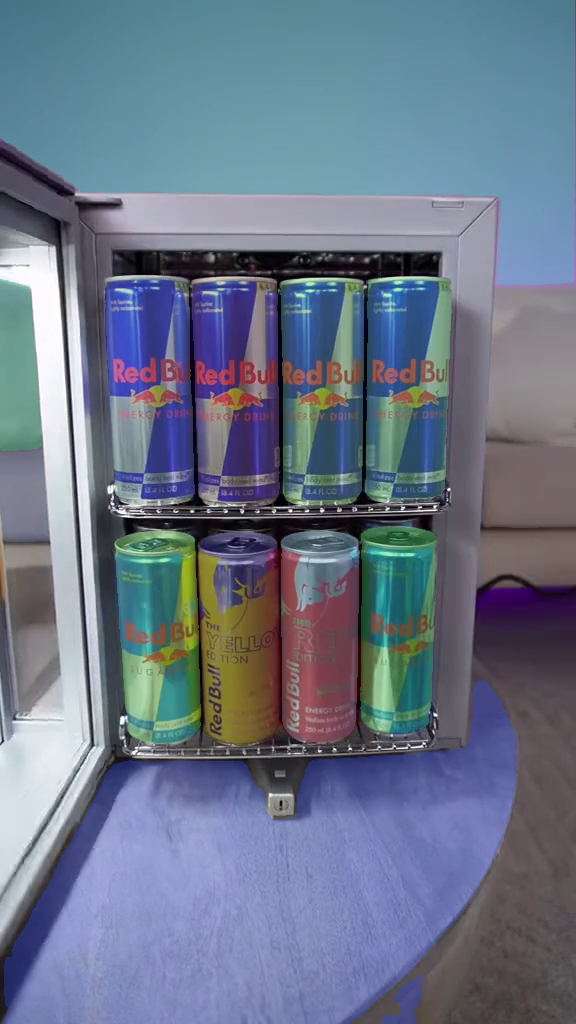

In [96]:
masks = mask_generator.generate(cv_image)
print(len(masks))
show_anns(image, masks)

/tmp/ipykernel_49519/1885970858.py:36: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  transparency_mask_image = Image.fromarray(transparency_mask, mode='L')


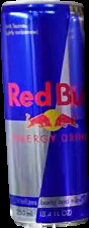

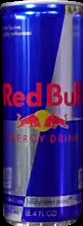

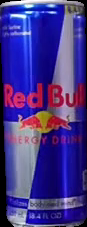

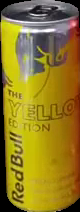

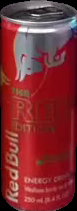

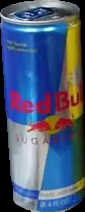

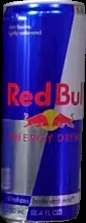

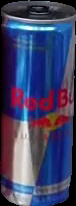

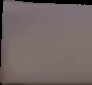

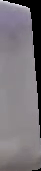

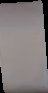

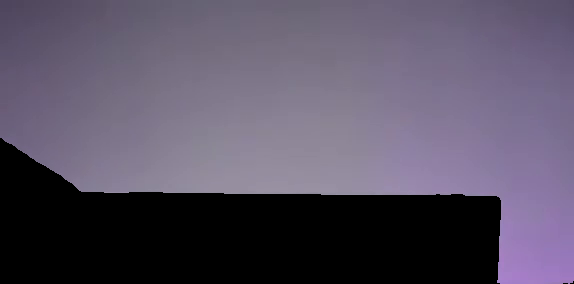

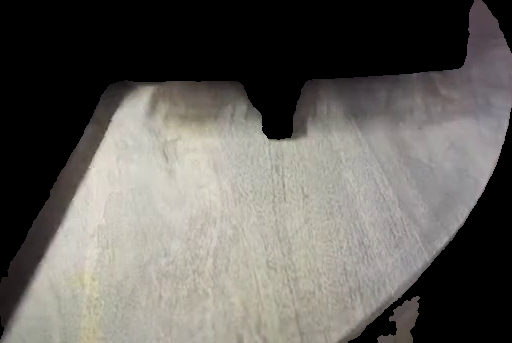

In [97]:
for mask in masks:
    img = segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"]))
    display(img)

In [98]:
# cropped_boxes = []

# for mask in masks:
#     cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

# scores = retriev(cropped_boxes, "beer")
# indices = get_indices_of_values_above_threshold(scores, 0.02)

# segmentation_masks = []

# for seg_idx in indices:
#     segmentation_mask_image = Image.fromarray(masks[seg_idx]["segmentation"].astype('uint8') * 255)
#     segmentation_masks.append(segmentation_mask_image)

# original_image = image.copy()
# overlay_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
# overlay_color = (255, 0, 0, 200)

# draw = ImageDraw.Draw(overlay_image)
# for segmentation_mask_image in segmentation_masks:
#     draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

# Image.alpha_composite(original_image.convert('RGBA'), overlay_image)

In [99]:
# from ultralytics import YOLO

# model = YOLO('yolo11l.pt')

# for i in cropped_boxes:
#     for r in model.predict(i, verbose=False):
#         print(r.summary())
    
#     # display(i)